In [1]:
# Script to look at the common reactions and find the ones that are most different
# Then take the 30 most different and generate 1000 cti files of the mixed models

In [159]:
import cantera as ct
import cantera.ck2cti
import rmgpy.chemkin
import numpy as np
import subprocess

import matplotlib.pyplot as plt

import time
import copy
import os

import scipy.stats

In [3]:
# load David's 2-BTP model, minus the halogens
# https://github.com/comocheng/halogen_models/tree/main/combustion_symposium_paper/supporting_material

RMG_chemkin_path = 'models/RMG_no_halogens/no_halogens.inp'
RMG_dictionary_path = 'models/RMG_no_halogens/no_halogens_dict.txt'
RMG_transport_path = 'models/RMG_no_halogens/no_halogens_tran.dat'
RMG_cti_path = 'models/RMG_no_halogens/no_halogens.cti'

RMG_species_list, RMG_reaction_list = rmgpy.chemkin.load_chemkin_file(RMG_chemkin_path, dictionary_path=RMG_dictionary_path, transport_path=RMG_transport_path)
RMG_gas = ct.Solution(RMG_cti_path)



In [6]:
# Load NIST model without halogens
NIST_cti_path = 'models/NIST_no_halogens/no_halogens.cti'
NIST_chemkin_path = 'models/NIST_no_halogens/no_halogens.inp'
NIST_dictionary_path = 'models/NIST_no_halogens/no_halogens_dict.txt'
NIST_transport_path = 'models/NIST_no_halogens/no_halogens_tran.dat'

NIST_gas = ct.Solution(NIST_cti_path)
NIST_dict = rmgpy.chemkin.load_species_dictionary(NIST_dictionary_path)
NIST_species_list, NIST_reaction_list = rmgpy.chemkin.load_chemkin_file(NIST_chemkin_path, dictionary_path=NIST_dictionary_path, transport_path=NIST_transport_path)


For species CH2OCH, discontinuity in cp/R detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  8.393471510000001
	Value computed using high-temperature polynomial: 9.1801039121875

For species CH2OCH, discontinuity in h/RT detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  42.199147089791666
	Value computed using high-temperature polynomial: 41.961461604875005

For species CH2OCH, discontinuity in s/R detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  33.70692865946735
	Value computed using high-temperature polynomial: 33.51209988778391

For species C4H5-2, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  47.65235236593109
	Value computed using high-temperature polynomial: 48.43623165666667

For species C4H5-2, discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  52.42918829260522
	Value computed using high-temperature p

In [141]:
# Species Diff
common_species = []
RMG2NIST_mapping = {}
NIST2RMG_mapping = {}
for i, rmg_sp in enumerate(RMG_species_list):
    for j, nist_sp in enumerate(NIST_species_list):
        if rmg_sp.is_isomorphic(nist_sp):
            RMG2NIST_mapping[i] = j
            NIST2RMG_mapping[j] = i
            common_species.append([rmg_sp, nist_sp])
            break

# Reaction Diff
common_reactions = []
RMG2NIST_rxn_mapping = {}
NIST2RMG_rxn_mapping = {}
for i, rmg_rxn in enumerate(RMG_reaction_list):
    for j, nist_rxn in enumerate(NIST_reaction_list):
        if rmg_rxn.is_isomorphic(nist_rxn):
            RMG2NIST_rxn_mapping[i] = j
            NIST2RMG_rxn_mapping[j] = i
            common_reactions.append([rmg_rxn, nist_rxn])
            break


In [143]:
# count the common reactions:

print(len(RMG2NIST_mapping))
print(len(RMG2NIST_rxn_mapping))
print(len(common_species))
print(len(common_reactions))

45
240
45
240


In [152]:
# define error as  (ln(k_nist) - ln(k_rmg))^2
def calc_kinetics_error(nist_rxn, rmg_rxn):
    T = np.linspace(300, 1000, 101)
    error = 0
    for i in range(0, len(T)):
        
        nist_rate = nist_rxn.get_rate_coefficient(T[i], 101325)
        rmg_rate = rmg_rxn.get_rate_coefficient(T[i], 101325)
#         if np.isnan(rmg_rate):
#             nist_rate = nist_rxn.kinetics.get_rate_coefficient(T[i], 101325)
#             rmg_rate = rmg_rxn.kinetics.get_rate_coefficient(T[i], 101325)
        error += np.float_power(np.log(nist_rate) - np.log(rmg_rate), 2.0)
    return error

In [153]:
len(common_reactions)

240

In [154]:
# find the reactions with the most different kinetics as defined by a mean squared error in the temperature range 300-1000K
errors = np.zeros(len(common_reactions))
for i, entry in enumerate(common_reactions):
    errors[i] = calc_kinetics_error(entry[1], entry[0])
#     print(i, errors[i])

In [155]:
# sort the reactions
order = np.argsort(errors)


In [156]:
def plot_kinetics(kinetics, labels=None):
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    T = np.linspace(300, 3000, 1001)
    for kinetic in kinetics:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = kinetic.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    plt.legend(labels)
    plt.show()

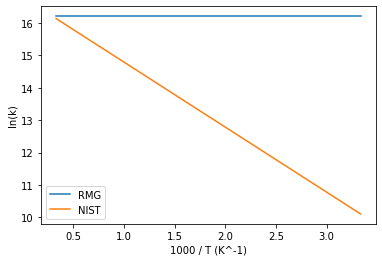

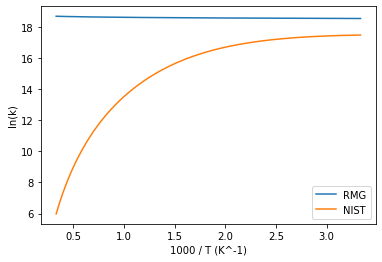

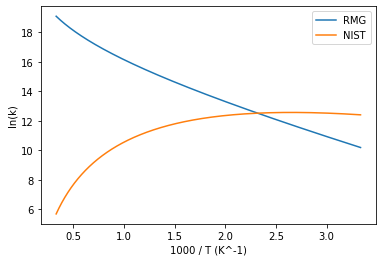

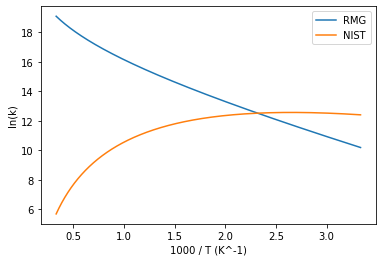

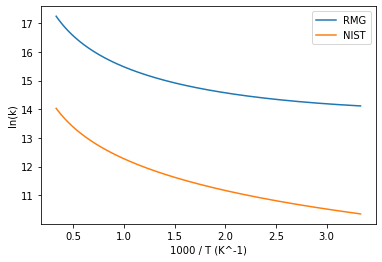

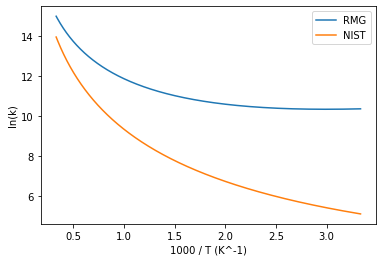

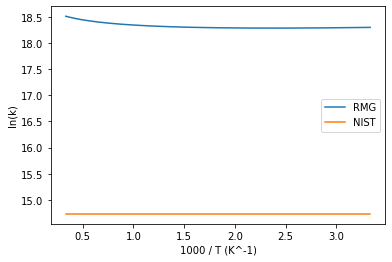

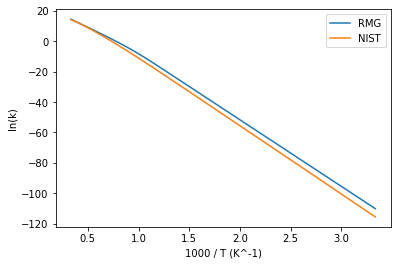

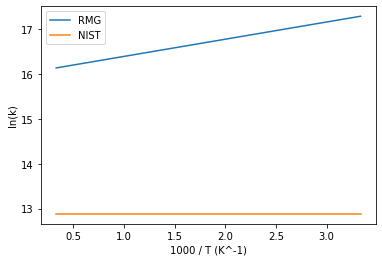

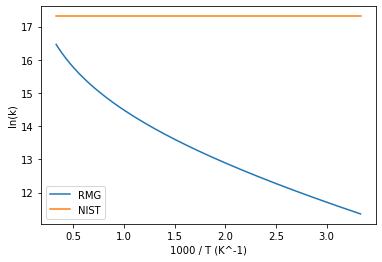

In [157]:
%matplotlib inline
i = order[3]
for j in range(200, 210):
    i = order[j]
    plot_kinetics(common_reactions[i], ['RMG', 'NIST'])
#     time.sleep(1.0)



In [158]:
# select the 30 most different reactions to try mixing
reactions_to_mix = []
reactions_to_mix_rmg_indices = []
N = 30
for i in range(-N, 0):
    index = order[i]
    reactions_to_mix.append(common_reactions[index])
    reactions_to_mix_rmg_indices.append(RMG_reaction_list.index(common_reactions[index][0]))
#     print(common_reactions[index][0])
# print(len(reactions_to_mix))

print(reactions_to_mix_rmg_indices)

[192, 586, 240, 663, 175, 176, 139, 181, 52, 110, 170, 211, 258, 669, 520, 133, 570, 80, 532, 582, 121, 171, 202, 277, 20, 257, 14, 222, 4, 11]
